The Generic Tone Mapping function could approximate most of known TM functions.
And I want parameter sets to approximate a given TM function. 
(asinh, log, filmic, for example)


And.. it didn't work well. Seems like parameter boundaries for MS function is limiting the output range. 

In [338]:
import numpy as np
import matplotlib.pyplot as plt 

In [339]:
def Mantiuk_Seidel(lum, b, c, dl, dh):
    """
    Condition:
        * b - dl < max(lp) = 0.45
        * b + dh > min(lp)

    NOTE
    ----
    The tone map function is dependent of input image. 
    It can't be constructed once and called by multiple different images.
    """
    al = (c*dl-1)/dl # contrast compression for shadows
    ah = (c*dh-1)/dh
    lp = np.log10(lum) # L prime
    
    conditions=[lp <= b-dl,
                (b-dl < lp) * (lp <= b),
                (b < lp) * (lp <= b+dh),
                lp > b+dh]

    functions=[0,
               lambda lp : 1/2*c*(lp-b)/(1-al*(lp-b))+1/2,
               lambda lp : 1/2*c*(lp-b)/(1+ah*(lp-b))+1/2,
               1]

    return np.piecewise(lp, conditions, functions)


def tm_generic(x, 
               a=0.125,
               d=0.975,
               mid_in=0.25,
               mid_out=0.18):
    """
    there's a set of rule among the parameters. 
    e.g., following the naming convention of Mantiuk*Seidel 08,
    1) b - dl < b 
    2) b < b + dh
    3) ... 
    
    """
    hdr_max = x.max()
    ad = a * d
    midi_pow_a  = np.power(mid_in, a)
    midi_pow_ad = np.power(mid_in, ad)
    hdrm_pow_a  = np.power(hdr_max, a)
    hdrm_pow_ad = np.power(hdr_max, ad)
    u = hdrm_pow_ad * mid_out - midi_pow_ad * mid_out
    v = midi_pow_ad * mid_out

    b = -((-midi_pow_a + (mid_out * (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v)) / u) / v)
    c = (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v) / u

    x[x>hdr_max] = hdr_max
    z = np.power(x, a)
    return z / (np.power(z, d) * b + c)

Assume images are normalized to [0,1]

실제로는 max는 1로 맞추고, 0은 0으로, 0이 아닌 min을 1e-6 이런 식으로.   
참고로 3e-5가 한쪽 side의 4sigma임. 

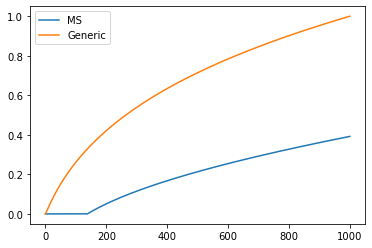

In [340]:
img = np.linspace(0, 1.1, 1000)
tmg_ms = Mantiuk_Seidel(img, *[0.18, 1.71, 1, 7.10])
tmg_gn = tm_generic(img, *[1.1, 0.7, 1.2, 1.04])

plt.plot(tmg_ms, label="MS")
plt.plot(tmg_gn, label="Generic")
plt.legend()
plt.show()

## lmfit 

sklearn으로 asinh에 비슷한거 찾기. 
  
Constrained Optimization problem임.   
Scipy의 optimize나 fit은 bound를 설정하기가 좀 불편함.   
lmfit을 사용하면 boundary를 함수의 형태로도 설정 가능. 
https://lmfit.github.io/lmfit-py/ 


In [80]:
from lmfit import Minimizer, Parameters, report_fit
from lmfit.lineshapes import gaussian, lorentzian

def residual(pars, x, data): 
    #model = tm_generic(x, pars['a'], pars['d'], pars['mid_in'], pars['mid_out'])
    model = Mantiuk_Seidel(x, pars[])
    return model - data

pfit = Parameters()
pfit.add(name='a', value=0.5)
pfit.add(name='d', value=0.5)
pfit.add(name='d_minus_in', value=1, vary=True, min=0)
pfit.add(name='in_minus_out', value=1, vary=True, min=0)
pfit.add(name='mid_in', expr='d - d_minus_in') # inequality 
pfit.add(name='mid_out', expr='mid_in - in_minus_out') # inequality 

In [103]:
def residual(pars, x, data): 
    model = Mantiuk_Seidel(x, pars['a'], pars['b'], pars['dl'], pars['dh'])
    return model - data

pfit = Parameters()
pfit.add(name='a', value=1, min=0, max=10)
pfit.add(name='b', value=1, min=0, max=10)
pfit.add(name='b_minus_dl', value=0.5, vary=True, min=0)
pfit.add(name='dl', expr='b - b_minus_dl', min=0)
pfit.add(name='dh', value=1, min=0) # inequality 

generic_tm은 constraint 관계를 잘 모르겠으나... MS는 내가 알고있지!   
MS로 다시 해보자. 


모든 변수 > 0
b - dl > 0 



In [105]:
data = tmo_asinh(xx)
mini = Minimizer(residual, pfit, fcn_args=(xx, data))
out = mini.leastsq()
best_fit = data + out.residual

In [108]:
report_fit(out.params)

[[Variables]]
    a:           0.25252460 (init = 1)
    b:           4.07974218 (init = 1)
    b_minus_dl:  4.10448890 (init = 0.5)
    dl:          0.00000000 == 'b - b_minus_dl'
    dh:          1.05725007 (init = 1)


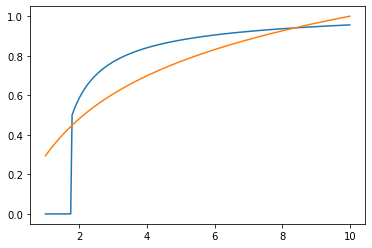

In [112]:
plt.plot(xx, best_fit)
plt.plot(xx, data)
plt.show()

뭐가 잘 맞았다는 것인가??? 

In [55]:
from astrobf import tmo

In [ ]:
from scipy import optimize

p_ = {'a':0.125, 'd':0.975, 'mid_in':0.25, 'mid_out':0.18} # == Uncharted

xx = 10**np.linspace(-6,0,100)


tmo_log = lambda xx : (np.log10(xx) - np.log10(xx).min())/np.log10(xx).ptp()

In [193]:
def asinh(xx_in, scale_min=None, scale_max=None, non_linear=2.0):
    xx = np.copy(xx_in)
    if scale_min == None:
        scale_min = xx.min()
    if scale_max == None:
        scale_max = xx.max()
    factor = np.arcsinh((scale_max - scale_min)/non_linear)
    indices0 = np.where(xx < scale_min)
    indices1 = np.where((xx >= scale_min) & (xx <= scale_max))
    indices2 = np.where(xx > scale_max)
    xx[indices0] = 0.0
    xx[indices2] = 1.0
    xx[indices1] = np.arcsinh((xx[indices1] - scale_min)/non_linear)/factor
    
    return xx #- xx.min() # shift to >0


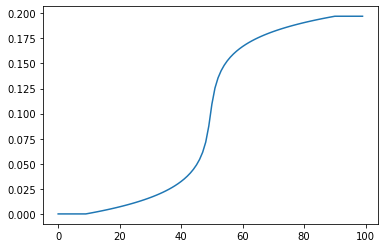

In [290]:
plt.plot(xx)

<ipython-input-42-90003b306008>:51: RuntimeWarning: invalid value encountered in double_scalars
  b = -((-midi_pow_a + (mid_out * (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v)) / u) / v)
<ipython-input-42-90003b306008>:52: RuntimeWarning: invalid value encountered in double_scalars
  c = (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v) / u
<ipython-input-42-90003b306008>:51: RuntimeWarning: divide by zero encountered in double_scalars
  b = -((-midi_pow_a + (mid_out * (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v)) / u) / v)
<ipython-input-42-90003b306008>:52: RuntimeWarning: divide by zero encountered in double_scalars
  c = (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v) / u
<ipython-input-42-90003b306008>:56: RuntimeWarning: invalid value encountered in add
  return z / (np.power(z, d) * b + c)
/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the paramete

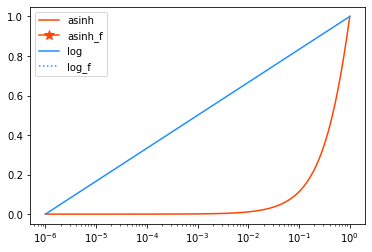

[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]
[ 1.  1.  1.  1.]


In [63]:
p_asinh, _ = optimize.curve_fit(tm_generic, xx, tmo_asinh(xx))
p_log, _ = optimize.curve_fit(tm_generic, xx, tmo_log(xx))
#p_ACEf,_ = optimize.curve_fit(tm_generic, xx, tmo.ACESFilm(xx))
#p_unchar, _ = optimize.curve_fit(tm_generic, xx, tmo.normalized_uncharted(xx, xx.max()))

params = [p_asinh, p_log, p_ACEf, p_unchar]

fig,ax = plt.subplots()

#ax.plot(xx, yy, label='generic')
ax.plot(xx, tmo_asinh(xx), label='asinh', c='orangered')
ax.plot(xx, tm_generic(xx, *p_asinh), label='asinh_f', c='orangered', marker='*', markersize=10)
ax.plot(xx, tmo_log(xx), label='log', c='dodgerblue')
ax.plot(xx, tm_generic(xx, *p_log), label='log_f', c='dodgerblue', ls=":")
#ax.plot(xx, tmo.ACESFilm(xx), label='ACE', c='limegreen')
#ax.plot(xx, tm_generic(xx, *p_ACEf), label='ACE_f', c='limegreen', ls=":")
#ax.plot(xx, tmo.uncharted(xx), label='unchar', c='hotpink')
#ax.plot(xx, tm_generic(xx, *p_unchar), label='unchar_f', c='hotpink', ls=":")

ax.set_xscale('log')
plt.legend()

plt.savefig("TMO_param_fittings.png", facecolor="white", dpi=200)
plt.show()


for pp in params:
    print(pp)

In [68]:
p_unchar

array([  1.09533468e+00,   9.99377882e-01,   3.14910557e+03,
         9.97440276e-01])

# Fitted params result in unstable images... Don't use them

In [113]:
plt.close("all")

In [115]:
params = [[1.68, 0.53, 4.12, 2.46],
          [1.38, 0.71, 1.99, 2.10],
          [1.90, 0.88, 2.43, 1.48],
          [1.30, 0.69, 2.53, 7.60]]

tmo_names = ['BriAda', 'log', 'Ashik', 'Retinex']

[1.68, 0.53, 4.12, 2.46]
[1.38, 0.71, 1.99, 2.1]
[1.9, 0.88, 2.43, 1.48]
[1.3, 0.69, 2.53, 7.6]


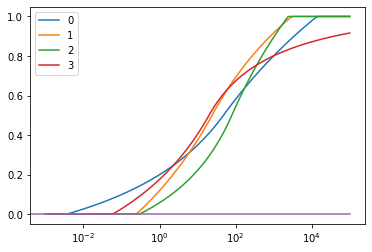

In [116]:
xx = 10**np.linspace(-3,5,100)
fig,ax = plt.subplots()
for i, pp in enumerate(params):
    print(pp)
    tmg = Mantiuk_Seidel(*pp)
    #ax.plot(xx, tm_generic(xx, *pp), label=f'{i}')
    ax.plot(xx, tmg.apply(xx), label=f'{i}')
ax.plot([0,1e5], [0,0])
ax.set_xscale('log')
plt.legend()
plt.show()

Scipy curve_fit (probably same for many other optimizations) introspects the parameters of the function in question. It requires the function be transparent (not wrapped). In my case, Mantiuk_Seidel function calls np.piecewise(), making it unsuitable for curve_fit.   
(Getting `ValueError: Unable to determine number of fit parameters.`)

So, I will turn to a more universal method, Bayesian Optimization.

In [117]:
xx = 10**np.linspace(-1,1,1000)

tmo_log = lambda xx : (np.log10(xx) - np.log10(xx).min())/np.log10(xx).ptp()
tmo_asinh = lambda xx : np.arcsinh(xx)/max(np.arcsinh(xx))

p_asinh, _ = optimize.curve_fit(Mantiuk_Seidel, xx, tmo_asinh(xx))
p_log, _ = optimize.curve_fit(Mantiuk_Seidel, xx, tmo_log(xx))
p_ACEf,_ = optimize.curve_fit(Mantiuk_Seidel, xx, tmo.ACESFilm(xx))
p_unchar, _ = optimize.curve_fit(Mantiuk_Seidel, xx, tmo.normalized_uncharted(xx, xx.max()))

params = [p_asinh, p_log, p_ACEf, p_unchar]

fig,ax = plt.subplots()

#ax.plot(xx, yy, label='generic')
ax.plot(xx, tmo_asinh(xx), label='asinh', c='orangered')
#ax.plot(xx, tm_generic(xx, *p_asinh), label='asinh_f', c='orangered', ls=':')
ax.plot(xx, tmo_log(xx), label='log', c='dodgerblue')
#ax.plot(xx, tm_generic(xx, *p_log), label='log_f', c='dodgerblue', ls=":")
ax.plot(xx, tmo.ACESFilm(xx), label='ACE', c='limegreen')
#ax.plot(xx, tm_generic(xx, *p_ACEf), label='ACE_f', c='limegreen', ls=":")
ax.plot(xx, tmo.uncharted(xx), label='unchar', c='hotpink')
#ax.plot(xx, tm_generic(xx, *p_unchar), label='unchar_f', c='hotpink', ls=":")

ax.set_xscale('log')
plt.legend()

#plt.savefig("TMO_param_fittings.png", facecolor="white", dpi=200)
plt.show()

for pp in params:
    print(pp)

ValueError: Unable to determine number of fit parameters.

In [154]:
plt.close("all")

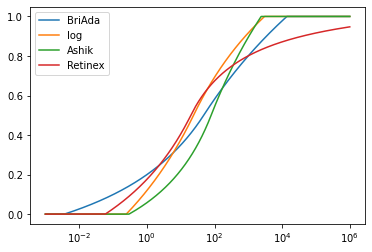

In [164]:
params = [[1.68, 0.53, 4.12, 2.46],
          [1.38, 0.71, 1.99, 2.10],
          [1.90, 0.88, 2.43, 1.48],
          [1.30, 0.69, 2.53, 7.60]]

tmo_names = ['BriAda', 'log', 'Ashik', 'Retinex']

xx = 10**np.linspace(-3,6,1000)

fig, ax = plt.subplots()
for pp, name in zip(params, tmo_names):
    ax.plot(xx, Mantiuk_Seidel(xx, *pp), label=name)
ax.set_xscale('log')
plt.legend()
plt.show()

I know it's super overkill, but... 

In [341]:
## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

In [310]:
from astrobf.analysis import multi_clustering as mucl

ax_params = mucl.gen_tmo_param_sets(1, no_numeric=True, min1=0.5, min2=0.3)

ax_params

[{'name': 'b', 'type': 'range', 'bounds': [0.5, 8.0], 'value_type': 'float'},
 {'name': 'c', 'type': 'range', 'bounds': [0.5, 8.0], 'value_type': 'float'},
 {'name': 'dl', 'type': 'range', 'bounds': [0.3, 15.0], 'value_type': 'float'},
 {'name': 'dh', 'type': 'range', 'bounds': [0.3, 15.0], 'value_type': 'float'}]

In [311]:
def eval_fn(params, xx, data):
    #np.sum(np.abs(Mantiuk_Seidel(xx) - tmo_asinh(xx)))
    return np.linalg.norm(Mantiuk_Seidel(xx, **params) - data)

In [150]:
# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./TMO_fit/'
fn_result = "fit_asinh"
#nTMs=1 

axc = AxClient()

axc.create_experiment(
    parameters=ax_params,
    objective_name="asinh",
    minimize=True,  # Optional, defaults to False.
    parameter_constraints=["b - dl <= 10", 
                           "dl - dh >= 0.1"], # all images are stretched to 100
    overwrite_existing_experiment =True,
    #outcome_constraints=["total_flux >= 1e-5"],  # Optional.
    )

for i in range(400):
    parameters, trial_index = axc.get_next_trial()
    axc.complete_trial(trial_index=trial_index,
                       raw_data=eval_fn(parameters,
                                        xx,
                                        tmo_asinh(xx))
                      )

if True:
    axc.save_to_json_file(exp_dir+fn_result+".json")
else:
    axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

[INFO 08-31 15:08:15] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 08-31 15:08:15] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 08-31 15:08:15] ax.service.ax_client: Generated new trial 0 with parameters {'b': 0.92, 'c': 4.09, 'dl': 12.32, 'dh': 3.89}.
[INFO 08-31 15:08:15] ax.service.ax_client: Completed trial 0 with data: {'asinh': (5.2699999999999996, None)}.
[INFO 08-31 15:08:15] ax.service.ax_client: Generated new trial 1 with parameters {'b': 1.91, 'c': 3.6, 'dl': 14.15, 'dh': 2.11}.
[INFO 08-31 15:08:15] ax.service.ax_client: Completed trial 1 with data: {'asinh': (5.6399999999999997, None)}.
[INFO 08-31 15:08:16] ax

[INFO 08-31 15:08:34] ax.service.ax_client: Completed trial 26 with data: {'asinh': (3.4399999999999999, None)}.
[INFO 08-31 15:08:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 17_0, 26_0, 13_0, 16_0
[INFO 08-31 15:08:35] ax.service.ax_client: Generated new trial 27 with parameters {'b': 1.35, 'c': 3.62, 'dl': 12.98, 'dh': 12.88}.
[INFO 08-31 15:08:35] ax.service.ax_client: Completed trial 27 with data: {'asinh': (3.4199999999999999, None)}.
[INFO 08-31 15:08:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 26_0, 16_0, 17_0, 13_0, 27_0
[INFO 08-31 15:08:36] ax.service.ax_client: Generated new trial 28 with parameters {'b': 1.35, 'c': 3.66, 'dl': 13.1, 'dh': 13.0}.
[INFO 08-31 15:08:36] ax.service.ax_client: Completed trial 28 with data: {'asinh': (3.4500000000000002, None)}.
[INFO 08-31 15:08:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 26_0, 16_0, 17_0, 13_0, 27_0, 28_0
[INFO 08-31 15:08:37] ax.service.a

[INFO 08-31 15:08:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 26_0, 41_0, 45_0, 16_0, 35_0, 17_0, 37_0, 40_0, 42_0, 13_0, 43_0, 33_0, 38_0, 27_0, 28_0
[INFO 08-31 15:08:58] ax.service.ax_client: Generated new trial 48 with parameters {'b': 1.42, 'c': 1.33, 'dl': 5.37, 'dh': 5.27}.
[INFO 08-31 15:08:58] ax.service.ax_client: Completed trial 48 with data: {'asinh': (1.6899999999999999, None)}.
[INFO 08-31 15:08:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 26_0, 41_0, 45_0, 16_0, 35_0, 17_0, 37_0, 40_0, 42_0, 13_0, 43_0, 33_0, 38_0, 27_0, 28_0
[INFO 08-31 15:09:00] ax.service.ax_client: Generated new trial 49 with parameters {'b': 1.44, 'c': 1.39, 'dl': 6.4, 'dh': 3.1}.
[INFO 08-31 15:09:00] ax.service.ax_client: Completed trial 49 with data: {'asinh': (1.72, None)}.
[INFO 08-31 15:09:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 26_0, 41_0, 45_0, 16_0, 35_0, 17_0, 37_0, 40_0, 42_0, 13_0, 43_0, 33_0, 38

[INFO 08-31 15:09:23] ax.service.ax_client: Generated new trial 66 with parameters {'b': 2.09, 'c': 4.07, 'dl': 15.0, 'dh': 14.9}.
[INFO 08-31 15:09:23] ax.service.ax_client: Completed trial 66 with data: {'asinh': (7.04, None)}.
[INFO 08-31 15:09:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 13_0, 43_0, 61_0, 57_0, 41_0, 17_0, 40_0, 64_0, 58_0, 33_0, 37_0, 65_0, 63_0, 38_0, 56_0, 28_0, 51_0, 26_0, 45_0, 16_0, 52_0, 35_0, 27_0, 54_0, 42_0
[INFO 08-31 15:09:25] ax.service.ax_client: Generated new trial 67 with parameters {'b': 0.69, 'c': 4.96, 'dl': 15.0, 'dh': 14.9}.
[INFO 08-31 15:09:25] ax.service.ax_client: Completed trial 67 with data: {'asinh': (6.7699999999999996, None)}.
[INFO 08-31 15:09:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 13_0, 43_0, 61_0, 57_0, 41_0, 17_0, 40_0, 64_0, 67_0, 58_0, 33_0, 37_0, 65_0, 63_0, 38_0, 56_0, 28_0, 51_0, 26_0, 45_0, 16_0, 52_0, 35_0, 27_0, 54_0, 42_0
[INFO 08-31 15:09:26] ax.service.ax_cl

[INFO 08-31 15:09:45] ax.service.ax_client: Completed trial 82 with data: {'asinh': (7.04, None)}.
[INFO 08-31 15:09:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 13_0, 69_0, 43_0, 61_0, 57_0, 81_0, 41_0, 68_0, 17_0, 40_0, 64_0, 67_0, 58_0, 33_0, 78_0, 37_0, 65_0, 63_0, 38_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 35_0, 27_0, 54_0, 42_0
[INFO 08-31 15:09:46] ax.service.ax_client: Generated new trial 83 with parameters {'b': 2.5, 'c': 8.0, 'dl': 12.96, 'dh': 12.86}.
[INFO 08-31 15:09:46] ax.service.ax_client: Completed trial 83 with data: {'asinh': (10.9, None)}.
[INFO 08-31 15:09:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 13_0, 69_0, 43_0, 61_0, 57_0, 81_0, 41_0, 68_0, 17_0, 40_0, 64_0, 67_0, 58_0, 33_0, 78_0, 37_0, 65_0, 63_0, 83_0, 38_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 35_0, 27_0, 54_0, 42_0
[INFO 08-31 15:09:47] ax.service.ax_client: Generated new trial

[INFO 08-31 15:10:06] ax.service.ax_client: Generated new trial 97 with parameters {'b': 2.22, 'c': 8.0, 'dl': 0.4, 'dh': 0.3}.
[INFO 08-31 15:10:06] ax.service.ax_client: Completed trial 97 with data: {'asinh': (10.33, None)}.
[INFO 08-31 15:10:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 13_0, 69_0, 43_0, 61_0, 57_0, 96_0, 81_0, 41_0, 68_0, 17_0, 40_0, 64_0, 67_0, 58_0, 33_0, 78_0, 84_0, 37_0, 65_0, 87_0, 63_0, 83_0, 88_0, 90_0, 38_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 35_0, 27_0, 54_0, 42_0, 89_0
[INFO 08-31 15:10:08] ax.service.ax_client: Generated new trial 98 with parameters {'b': 1.34, 'c': 5.85, 'dl': 4.98, 'dh': 4.88}.
[INFO 08-31 15:10:08] ax.service.ax_client: Completed trial 98 with data: {'asinh': (4.6799999999999997, None)}.
[INFO 08-31 15:10:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 13_0, 69_0, 43_0, 61_0, 57_0, 96_0, 81_0, 41_0, 68_0, 17_0, 40_0, 64_0, 67_0, 58_

[INFO 08-31 15:10:24] ax.service.ax_client: Generated new trial 111 with parameters {'b': 1.37, 'c': 1.15, 'dl': 3.42, 'dh': 3.32}.
[INFO 08-31 15:10:24] ax.service.ax_client: Completed trial 111 with data: {'asinh': (1.3200000000000001, None)}.
[INFO 08-31 15:10:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 13_0, 69_0, 43_0, 61_0, 57_0, 107_0, 96_0, 81_0, 41_0, 68_0, 17_0, 40_0, 64_0, 67_0, 58_0, 33_0, 78_0, 84_0, 109_0, 37_0, 65_0, 87_0, 63_0, 83_0, 88_0, 90_0, 38_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 35_0, 27_0, 54_0, 42_0, 89_0
[INFO 08-31 15:10:25] ax.service.ax_client: Generated new trial 112 with parameters {'b': 1.06, 'c': 3.74, 'dl': 7.88, 'dh': 7.78}.
[INFO 08-31 15:10:25] ax.service.ax_client: Completed trial 112 with data: {'asinh': (4.2699999999999996, None)}.
[INFO 08-31 15:10:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 13_0, 69_0, 43_0, 61_0, 57_0, 107

[INFO 08-31 15:10:41] ax.service.ax_client: Completed trial 124 with data: {'asinh': (12.9, None)}.
[INFO 08-31 15:10:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 123_0, 13_0, 115_0, 69_0, 43_0, 61_0, 57_0, 107_0, 96_0, 81_0, 41_0, 68_0, 17_0, 40_0, 116_0, 64_0, 58_0, 67_0, 33_0, 78_0, 114_0, 84_0, 109_0, 112_0, 37_0, 65_0, 87_0, 63_0, 83_0, 88_0, 90_0, 38_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 35_0, 27_0, 54_0, 42_0, 89_0
[INFO 08-31 15:10:43] ax.service.ax_client: Generated new trial 125 with parameters {'b': 1.33, 'c': 1.18, 'dl': 3.17, 'dh': 3.07}.
[INFO 08-31 15:10:43] ax.service.ax_client: Completed trial 125 with data: {'asinh': (1.28, None)}.
[INFO 08-31 15:10:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 123_0, 13_0, 115_0, 69_0, 43_0, 61_0, 57_0, 107_0, 96_0, 81_0, 41_0, 68_0, 17_0, 40_0, 116_0, 64_0, 58_0, 67_0, 33_0, 78_0, 114_0, 84_0, 109_0, 112_0, 37_0, 6

[INFO 08-31 15:11:01] ax.service.ax_client: Generated new trial 137 with parameters {'b': 1.47, 'c': 1.01, 'dl': 5.99, 'dh': 5.89}.
[INFO 08-31 15:11:01] ax.service.ax_client: Completed trial 137 with data: {'asinh': (2.0800000000000001, None)}.
[INFO 08-31 15:11:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 123_0, 13_0, 115_0, 69_0, 43_0, 61_0, 57_0, 107_0, 126_0, 96_0, 81_0, 41_0, 68_0, 17_0, 40_0, 116_0, 64_0, 133_0, 58_0, 33_0, 67_0, 78_0, 129_0, 114_0, 131_0, 84_0, 109_0, 112_0, 37_0, 65_0, 87_0, 63_0, 83_0, 88_0, 90_0, 38_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 35_0, 89_0, 127_0, 27_0, 54_0, 42_0, 135_0
[INFO 08-31 15:11:02] ax.service.ax_client: Generated new trial 138 with parameters {'b': 0.86, 'c': 3.57, 'dl': 5.49, 'dh': 5.39}.
[INFO 08-31 15:11:02] ax.service.ax_client: Completed trial 138 with data: {'asinh': (5.3200000000000003, None)}.
[INFO 08-31 15:11:03] ax.modelbridge.base: Leaving out out-of-desig

[INFO 08-31 15:11:20] ax.service.ax_client: Generated new trial 149 with parameters {'b': 1.31, 'c': 3.42, 'dl': 7.3, 'dh': 7.2}.
[INFO 08-31 15:11:20] ax.service.ax_client: Completed trial 149 with data: {'asinh': (3.3799999999999999, None)}.
[INFO 08-31 15:11:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 123_0, 13_0, 115_0, 69_0, 43_0, 61_0, 57_0, 107_0, 126_0, 96_0, 81_0, 41_0, 68_0, 17_0, 40_0, 116_0, 64_0, 133_0, 58_0, 33_0, 27_0, 67_0, 78_0, 142_0, 138_0, 114_0, 131_0, 129_0, 147_0, 84_0, 112_0, 37_0, 65_0, 87_0, 139_0, 63_0, 83_0, 88_0, 90_0, 38_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 35_0, 89_0, 127_0, 148_0, 109_0, 54_0, 140_0, 42_0, 135_0
[INFO 08-31 15:11:21] ax.service.ax_client: Generated new trial 150 with parameters {'b': 1.04, 'c': 6.21, 'dl': 7.43, 'dh': 7.33}.
[INFO 08-31 15:11:21] ax.service.ax_client: Completed trial 150 with data: {'asinh': (5.3700000000000001, None)}.
[INFO 08-31 15:11:23] ax.mo

[INFO 08-31 15:11:39] ax.service.ax_client: Completed trial 160 with data: {'asinh': (16.129999999999999, None)}.
[INFO 08-31 15:11:40] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 123_0, 13_0, 115_0, 69_0, 43_0, 61_0, 158_0, 57_0, 107_0, 126_0, 152_0, 96_0, 81_0, 160_0, 41_0, 68_0, 17_0, 40_0, 116_0, 64_0, 133_0, 58_0, 33_0, 27_0, 67_0, 78_0, 142_0, 151_0, 138_0, 114_0, 131_0, 129_0, 147_0, 84_0, 112_0, 37_0, 65_0, 87_0, 139_0, 63_0, 83_0, 88_0, 90_0, 38_0, 155_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 35_0, 89_0, 127_0, 148_0, 109_0, 54_0, 140_0, 42_0, 135_0
[INFO 08-31 15:11:40] ax.service.ax_client: Generated new trial 161 with parameters {'b': 1.1, 'c': 5.54, 'dl': 11.97, 'dh': 11.87}.
[INFO 08-31 15:11:40] ax.service.ax_client: Completed trial 161 with data: {'asinh': (4.8499999999999996, None)}.
[INFO 08-31 15:11:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 123_0, 13_

[INFO 08-31 15:11:59] ax.service.ax_client: Generated new trial 171 with parameters {'b': 2.59, 'c': 5.53, 'dl': 7.93, 'dh': 7.83}.
[INFO 08-31 15:11:59] ax.service.ax_client: Completed trial 171 with data: {'asinh': (11.16, None)}.
[INFO 08-31 15:12:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 123_0, 13_0, 115_0, 69_0, 43_0, 61_0, 158_0, 57_0, 107_0, 126_0, 152_0, 96_0, 81_0, 160_0, 41_0, 68_0, 17_0, 40_0, 116_0, 64_0, 133_0, 58_0, 33_0, 27_0, 168_0, 67_0, 78_0, 142_0, 151_0, 138_0, 114_0, 131_0, 129_0, 147_0, 84_0, 112_0, 37_0, 65_0, 87_0, 139_0, 63_0, 83_0, 161_0, 88_0, 90_0, 38_0, 155_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 35_0, 89_0, 127_0, 148_0, 167_0, 109_0, 54_0, 140_0, 42_0, 135_0
[INFO 08-31 15:12:01] ax.service.ax_client: Generated new trial 172 with parameters {'b': 1.39, 'c': 3.05, 'dl': 9.78, 'dh': 9.68}.
[INFO 08-31 15:12:01] ax.service.ax_client: Completed trial 172 with data: {'asinh': (3.06000000

[INFO 08-31 15:12:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 123_0, 13_0, 115_0, 69_0, 43_0, 61_0, 158_0, 57_0, 107_0, 126_0, 152_0, 96_0, 81_0, 160_0, 41_0, 68_0, 17_0, 40_0, 116_0, 64_0, 133_0, 175_0, 33_0, 27_0, 168_0, 58_0, 67_0, 142_0, 78_0, 179_0, 151_0, 138_0, 114_0, 131_0, 129_0, 147_0, 84_0, 112_0, 37_0, 65_0, 87_0, 139_0, 63_0, 83_0, 161_0, 173_0, 88_0, 90_0, 38_0, 155_0, 79_0, 56_0, 28_0, 82_0, 51_0, 26_0, 45_0, 73_0, 16_0, 52_0, 177_0, 35_0, 89_0, 127_0, 148_0, 167_0, 172_0, 109_0, 54_0, 140_0, 42_0, 135_0
[INFO 08-31 15:12:20] ax.service.ax_client: Generated new trial 182 with parameters {'b': 1.28, 'c': 2.87, 'dl': 7.77, 'dh': 7.67}.
[INFO 08-31 15:12:20] ax.service.ax_client: Completed trial 182 with data: {'asinh': (2.98, None)}.
[INFO 08-31 15:12:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 76_0, 70_0, 106_0, 123_0, 13_0, 115_0, 69_0, 43_0, 61_0, 158_0, 57_0, 107_0, 126_0, 152_0, 96_0, 81_0,

[INFO 08-31 15:12:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 115_0, 69_0, 158_0, 160_0, 41_0, 68_0, 40_0, 133_0, 175_0, 142_0, 151_0, 139_0, 83_0, 161_0, 38_0, 26_0, 172_0, 54_0, 135_0, 76_0, 123_0, 61_0, 126_0, 96_0, 116_0, 67_0, 138_0, 114_0, 186_0, 112_0, 87_0, 88_0, 56_0, 177_0, 35_0, 148_0, 167_0, 27_0, 109_0, 140_0, 42_0, 89_0, 70_0, 43_0, 57_0, 58_0, 33_0, 129_0, 84_0, 65_0, 79_0, 183_0, 45_0, 127_0, 106_0, 13_0, 107_0, 152_0, 81_0, 17_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0
[INFO 08-31 15:12:41] ax.service.ax_client: Generated new trial 192 with parameters {'b': 1.38, 'c': 1.11, 'dl': 7.22, 'dh': 7.12}.
[INFO 08-31 15:12:41] ax.service.ax_client: Completed trial 192 with data: {'asinh': (1.9199999999999999, None)}.
[INFO 08-31 15:12:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 115_0, 69_0, 158_0, 160_0, 41_0, 68_0, 40_0, 133_0, 175_0, 142_0, 151_0, 1

[INFO 08-31 15:13:01] ax.service.ax_client: Generated new trial 201 with parameters {'b': 1.38, 'c': 4.01, 'dl': 13.73, 'dh': 7.3}.
[INFO 08-31 15:13:01] ax.service.ax_client: Completed trial 201 with data: {'asinh': (3.71, None)}.
[INFO 08-31 15:13:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 115_0, 69_0, 158_0, 160_0, 41_0, 68_0, 40_0, 133_0, 175_0, 142_0, 151_0, 139_0, 83_0, 161_0, 38_0, 26_0, 172_0, 54_0, 135_0, 76_0, 123_0, 61_0, 126_0, 96_0, 116_0, 67_0, 138_0, 114_0, 186_0, 112_0, 87_0, 88_0, 56_0, 177_0, 35_0, 148_0, 167_0, 27_0, 109_0, 140_0, 42_0, 89_0, 70_0, 43_0, 57_0, 192_0, 58_0, 33_0, 129_0, 84_0, 65_0, 79_0, 183_0, 45_0, 127_0, 193_0, 106_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:13:03] ax.service.ax_client: Generated new trial 202 with parameters {'b': 5.59, 'c': 5.6, 'dl': 9.63, 'dh': 5.88}.
[INFO 08-31 15:13:03]

[INFO 08-31 15:13:23] ax.service.ax_client: Generated new trial 211 with parameters {'b': 5.94, 'c': 1.34, 'dl': 4.55, 'dh': 4.45}.
[INFO 08-31 15:13:23] ax.service.ax_client: Completed trial 211 with data: {'asinh': (16.25, None)}.
[INFO 08-31 15:13:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 115_0, 69_0, 158_0, 160_0, 41_0, 68_0, 40_0, 133_0, 175_0, 142_0, 151_0, 139_0, 83_0, 161_0, 38_0, 26_0, 172_0, 54_0, 135_0, 76_0, 123_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 88_0, 56_0, 204_0, 177_0, 35_0, 148_0, 167_0, 27_0, 109_0, 140_0, 42_0, 89_0, 70_0, 43_0, 211_0, 57_0, 192_0, 58_0, 33_0, 129_0, 84_0, 65_0, 79_0, 183_0, 45_0, 127_0, 193_0, 106_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:13:26] ax.service.ax_client: Generated new trial 212 with parameters {'b': 7.08, 'c': 5.78, 'dl': 12.21, 'dh': 6.5}

[INFO 08-31 15:13:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 115_0, 69_0, 158_0, 160_0, 41_0, 68_0, 40_0, 133_0, 175_0, 142_0, 151_0, 139_0, 83_0, 161_0, 38_0, 26_0, 172_0, 54_0, 135_0, 76_0, 123_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 88_0, 56_0, 204_0, 177_0, 35_0, 148_0, 167_0, 27_0, 109_0, 140_0, 42_0, 89_0, 70_0, 43_0, 211_0, 57_0, 192_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 45_0, 127_0, 193_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:13:47] ax.service.ax_client: Generated new trial 221 with parameters {'b': 1.59, 'c': 7.03, 'dl': 5.67, 'dh': 3.6}.
[INFO 08-31 15:13:47] ax.service.ax_client: Completed trial 221 with data: {'asinh': (5.4299999999999997, None)}.
[INFO 08-31 15:13:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 115_0, 69_0,

[INFO 08-31 15:14:10] ax.service.ax_client: Generated new trial 230 with parameters {'b': 2.6, 'c': 1.09, 'dl': 8.41, 'dh': 3.9}.
[INFO 08-31 15:14:10] ax.service.ax_client: Completed trial 230 with data: {'asinh': (8.3399999999999999, None)}.
[INFO 08-31 15:14:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 115_0, 69_0, 158_0, 160_0, 41_0, 68_0, 40_0, 133_0, 175_0, 142_0, 151_0, 139_0, 83_0, 161_0, 38_0, 26_0, 172_0, 54_0, 135_0, 76_0, 123_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 88_0, 56_0, 204_0, 177_0, 35_0, 148_0, 167_0, 27_0, 109_0, 140_0, 42_0, 89_0, 70_0, 43_0, 211_0, 57_0, 192_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 45_0, 127_0, 193_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:14:13] ax.service.ax_client: Generated new trial 231 with parameters {'b': 1.17, 'c

[INFO 08-31 15:14:35] ax.service.ax_client: Generated new trial 239 with parameters {'b': 2.84, 'c': 4.39, 'dl': 9.69, 'dh': 9.59}.
[INFO 08-31 15:14:35] ax.service.ax_client: Completed trial 239 with data: {'asinh': (12.529999999999999, None)}.
[INFO 08-31 15:14:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 115_0, 69_0, 158_0, 160_0, 41_0, 234_0, 68_0, 40_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 83_0, 161_0, 38_0, 26_0, 172_0, 54_0, 135_0, 76_0, 123_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 88_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 167_0, 27_0, 109_0, 140_0, 42_0, 89_0, 70_0, 43_0, 211_0, 57_0, 192_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 45_0, 127_0, 193_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:14:38] ax.service.ax_client: Generated new trial 240 

[INFO 08-31 15:15:00] ax.service.ax_client: Generated new trial 248 with parameters {'b': 6.13, 'c': 2.59, 'dl': 6.88, 'dh': 6.78}.
[INFO 08-31 15:15:00] ax.service.ax_client: Completed trial 248 with data: {'asinh': (16.170000000000002, None)}.
[INFO 08-31 15:15:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 115_0, 69_0, 158_0, 160_0, 41_0, 234_0, 68_0, 40_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 83_0, 161_0, 38_0, 26_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 140_0, 42_0, 89_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 45_0, 127_0, 193_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 248_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:15:03] ax.service.

[INFO 08-31 15:15:25] ax.service.ax_client: Generated new trial 257 with parameters {'b': 1.53, 'c': 1.56, 'dl': 6.98, 'dh': 6.88}.
[INFO 08-31 15:15:25] ax.service.ax_client: Completed trial 257 with data: {'asinh': (2.23, None)}.
[INFO 08-31 15:15:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 115_0, 69_0, 158_0, 160_0, 41_0, 234_0, 68_0, 40_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 83_0, 161_0, 38_0, 26_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 45_0, 249_0, 127_0, 193_0, 253_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 257_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 248_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 

[INFO 08-31 15:15:48] ax.service.ax_client: Completed trial 265 with data: {'asinh': (16.43, None)}.
[INFO 08-31 15:15:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 83_0, 161_0, 38_0, 26_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 45_0, 249_0, 127_0, 193_0, 253_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 257_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 248_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:15:51] ax.service.ax_client: Generated new trial 266 with parameters {'b': 0.96, 'c': 6.26, 'dl': 9.29, 'dh

[INFO 08-31 15:16:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 83_0, 161_0, 38_0, 26_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 45_0, 249_0, 127_0, 193_0, 253_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 257_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 248_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:16:13] ax.service.ax_client: Generated new trial 274 with parameters {'b': 0.51, 'c': 2.8, 'dl': 14.48, 'dh': 5.44}.
[INFO 08-31 15:16:13] ax.service.ax_client: Completed trial 274 with d

[INFO 08-31 15:16:32] ax.service.ax_client: Completed trial 281 with data: {'asinh': (7.2699999999999996, None)}.
[INFO 08-31 15:16:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 83_0, 161_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 45_0, 249_0, 127_0, 277_0, 193_0, 253_0, 278_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 257_0, 64_0, 168_0, 78_0, 179_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 248_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:16:35] ax.service.ax_client: Generated

[INFO 08-31 15:16:57] ax.service.ax_client: Generated new trial 289 with parameters {'b': 1.96, 'c': 1.78, 'dl': 1.78, 'dh': 1.68}.
[INFO 08-31 15:16:57] ax.service.ax_client: Completed trial 289 with data: {'asinh': (5.8300000000000001, None)}.
[INFO 08-31 15:16:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 83_0, 161_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 45_0, 249_0, 284_0, 127_0, 277_0, 193_0, 253_0, 278_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 257_0, 64_0, 168_0, 78_0, 179_0, 13

[INFO 08-31 15:17:21] ax.service.ax_client: Generated new trial 297 with parameters {'b': 1.56, 'c': 5.29, 'dl': 9.15, 'dh': 9.05}.
[INFO 08-31 15:17:21] ax.service.ax_client: Completed trial 297 with data: {'asinh': (4.6799999999999997, None)}.
[INFO 08-31 15:17:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 83_0, 161_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 193_0, 253_0, 278_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 257_0, 64_0, 168_0, 7

[INFO 08-31 15:17:46] ax.service.ax_client: Generated new trial 305 with parameters {'b': 2.44, 'c': 4.19, 'dl': 8.36, 'dh': 8.26}.
[INFO 08-31 15:17:46] ax.service.ax_client: Completed trial 305 with data: {'asinh': (9.6199999999999992, None)}.
[INFO 08-31 15:17:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 83_0, 161_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 193_0, 253_0, 278_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 257_0, 298_0, 

[INFO 08-31 15:18:12] ax.service.ax_client: Generated new trial 313 with parameters {'b': 0.95, 'c': 3.91, 'dl': 8.44, 'dh': 8.34}.
[INFO 08-31 15:18:12] ax.service.ax_client: Completed trial 313 with data: {'asinh': (4.8600000000000003, None)}.
[INFO 08-31 15:18:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 83_0, 161_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 193_0, 253_0, 278_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 17_0, 257_0, 298_0, 

[INFO 08-31 15:18:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 314_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 317_0, 193_0, 253_0, 278_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0, 81_0, 316_0, 17_0, 257_0, 298_0, 64_0, 168_0, 78_0, 179_0, 299_0, 131_0, 147_0, 37_0, 63_0, 173_0, 90_0, 155_0, 248_0, 28_0, 82_0, 51_0, 73_0, 16_0, 52_0, 199_0
[INFO 08-31 15:18:38] ax.service.ax_client: Generated new trial 321 with parameters {'b': 

[INFO 08-31 15:19:01] ax.service.ax_client: Generated new trial 328 with parameters {'b': 6.96, 'c': 0.5, 'dl': 9.16, 'dh': 5.15}.
[INFO 08-31 15:19:01] ax.service.ax_client: Completed trial 328 with data: {'asinh': (14.699999999999999, None)}.
[INFO 08-31 15:19:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 314_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 317_0, 193_0, 253_0, 278_0, 106_0, 216_0, 13_0, 107_0, 195_0, 152_0,

[INFO 08-31 15:19:26] ax.service.ax_client: Generated new trial 335 with parameters {'b': 1.01, 'c': 2.59, 'dl': 13.18, 'dh': 9.93}.
[INFO 08-31 15:19:26] ax.service.ax_client: Completed trial 335 with data: {'asinh': (3.75, None)}.
[INFO 08-31 15:19:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 129_0, 84_0, 65_0, 215_0, 314_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 317_0, 331_0, 193_0, 253_0, 278_0, 106_0, 216_0, 13_0, 332_0, 107_

[INFO 08-31 15:19:51] ax.service.ax_client: Generated new trial 342 with parameters {'b': 4.46, 'c': 5.76, 'dl': 11.58, 'dh': 9.68}.
[INFO 08-31 15:19:51] ax.service.ax_client: Completed trial 342 with data: {'asinh': (15.93, None)}.
[INFO 08-31 15:19:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 339_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 340_0, 129_0, 84_0, 65_0, 215_0, 314_0, 336_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 317_0, 331_0, 193_0, 253_0, 278_0, 106_0, 21

[INFO 08-31 15:20:17] ax.service.ax_client: Generated new trial 349 with parameters {'b': 5.3, 'c': 1.73, 'dl': 6.95, 'dh': 2.46}.
[INFO 08-31 15:20:17] ax.service.ax_client: Completed trial 349 with data: {'asinh': (15.550000000000001, None)}.
[INFO 08-31 15:20:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 268_0, 115_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 339_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 340_0, 129_0, 84_0, 65_0, 215_0, 314_0, 336_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 317_0, 331_0, 193_0, 253_0, 278_0

[INFO 08-31 15:20:43] ax.service.ax_client: Generated new trial 356 with parameters {'b': 1.29, 'c': 1.54, 'dl': 5.22, 'dh': 5.12}.
[INFO 08-31 15:20:43] ax.service.ax_client: Completed trial 356 with data: {'asinh': (1.78, None)}.
[INFO 08-31 15:20:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 354_0, 268_0, 115_0, 356_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 355_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 339_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 340_0, 129_0, 84_0, 65_0, 215_0, 314_0, 336_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 317_0, 331_0, 193_0, 253_

[INFO 08-31 15:21:10] ax.service.ax_client: Generated new trial 363 with parameters {'b': 1.21, 'c': 2.12, 'dl': 4.68, 'dh': 0.75}.
[INFO 08-31 15:21:10] ax.service.ax_client: Completed trial 363 with data: {'asinh': (4.46, None)}.
[INFO 08-31 15:21:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 354_0, 268_0, 115_0, 356_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 355_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 361_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 339_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 340_0, 129_0, 84_0, 65_0, 215_0, 314_0, 336_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 317_0, 331_0, 193_

[INFO 08-31 15:21:36] ax.service.ax_client: Generated new trial 370 with parameters {'b': 5.38, 'c': 5.07, 'dl': 8.82, 'dh': 8.44}.
[INFO 08-31 15:21:36] ax.service.ax_client: Completed trial 370 with data: {'asinh': (16.18, None)}.
[INFO 08-31 15:21:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 354_0, 268_0, 115_0, 356_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 355_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 361_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 339_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 340_0, 129_0, 84_0, 365_0, 65_0, 215_0, 314_0, 336_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 317_0, 331

[INFO 08-31 15:22:04] ax.service.ax_client: Generated new trial 377 with parameters {'b': 5.44, 'c': 5.62, 'dl': 3.91, 'dh': 0.75}.
[INFO 08-31 15:22:04] ax.service.ax_client: Completed trial 377 with data: {'asinh': (16.52, None)}.
[INFO 08-31 15:22:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 354_0, 268_0, 115_0, 356_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 355_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 361_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 339_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 58_0, 33_0, 340_0, 129_0, 84_0, 365_0, 65_0, 215_0, 314_0, 336_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_0, 317_0, 331

[INFO 08-31 15:22:33] ax.service.ax_client: Generated new trial 384 with parameters {'b': 2.14, 'c': 0.79, 'dl': 11.36, 'dh': 11.26}.
[INFO 08-31 15:22:33] ax.service.ax_client: Completed trial 384 with data: {'asinh': (5.5099999999999998, None)}.
[INFO 08-31 15:22:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 354_0, 268_0, 115_0, 356_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 355_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 361_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 379_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 339_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 380_0, 58_0, 33_0, 340_0, 129_0, 84_0, 365_0, 65_0, 215_0, 314_0, 336_0, 79_0, 183_0, 291_0, 249_0, 45_0, 28

[INFO 08-31 15:23:03] ax.service.ax_client: Generated new trial 391 with parameters {'b': 1.36, 'c': 1.96, 'dl': 7.39, 'dh': 7.29}.
[INFO 08-31 15:23:03] ax.service.ax_client: Completed trial 391 with data: {'asinh': (2.1000000000000001, None)}.
[INFO 08-31 15:23:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 354_0, 268_0, 115_0, 356_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 355_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 361_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 379_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 339_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 380_0, 58_0, 33_0, 340_0, 129_0, 84_0, 365_0, 65_0, 215_0, 314_0, 336_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_

[INFO 08-31 15:23:32] ax.service.ax_client: Generated new trial 398 with parameters {'b': 1.26, 'c': 1.45, 'dl': 3.18, 'dh': 3.08}.
[INFO 08-31 15:23:32] ax.service.ax_client: Completed trial 398 with data: {'asinh': (1.73, None)}.
[INFO 08-31 15:23:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 223_0, 236_0, 354_0, 268_0, 115_0, 356_0, 69_0, 158_0, 258_0, 160_0, 41_0, 234_0, 68_0, 40_0, 276_0, 133_0, 175_0, 142_0, 238_0, 151_0, 139_0, 255_0, 320_0, 161_0, 83_0, 329_0, 38_0, 355_0, 280_0, 26_0, 279_0, 273_0, 172_0, 54_0, 135_0, 76_0, 123_0, 244_0, 61_0, 126_0, 96_0, 292_0, 303_0, 321_0, 116_0, 67_0, 361_0, 209_0, 138_0, 114_0, 186_0, 112_0, 87_0, 243_0, 88_0, 263_0, 267_0, 333_0, 379_0, 56_0, 204_0, 232_0, 177_0, 35_0, 148_0, 240_0, 167_0, 27_0, 109_0, 252_0, 140_0, 42_0, 89_0, 285_0, 70_0, 339_0, 43_0, 211_0, 57_0, 192_0, 241_0, 260_0, 380_0, 58_0, 33_0, 340_0, 129_0, 84_0, 365_0, 65_0, 215_0, 314_0, 336_0, 79_0, 183_0, 291_0, 249_0, 45_0, 284_0, 127_0, 277_

In [145]:
best_parameters, values = axc.get_best_parameters()


[{'name': 'b', 'type': 'range', 'bounds': [0.5, 8.0], 'value_type': 'float'},
 {'name': 'c', 'type': 'range', 'bounds': [0.5, 8.0], 'value_type': 'float'},
 {'name': 'dl', 'type': 'range', 'bounds': [0.3, 15.0], 'value_type': 'float'},
 {'name': 'dh', 'type': 'range', 'bounds': [0.3, 15.0], 'value_type': 'float'}]

예상보다 다음 point를 고르는 과정이 굉장히 오래 걸림. 정말로 overkill인 듯. 

# Scikit-optimize 

Note that it is conventionally imported as 'skopt', but there is another package called SKOPT.
>SKOPT is a software tool intended to automate the optimisation of parameters for the Density Functional Tight Binding (DFTB) theory. ...

So, don't get confuseed scikit-optimize with it when searching for documents.

In [342]:
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

In [343]:
def asinh(xx_in, 
              xcen = 0.5, 
              scale_min = 0.1, 
              scale_max = 0.9,
              non_linear = 0.01
             ):
    xx = np.copy(xx_in)
    #factor = np.arcsinh((scale_max - scale_min)/non_linear)
    ind0 = np.where(xx < scale_min)[0]
    ind2 = np.where(xx > scale_max)[0]

    #indices1 = np.where((xx >= scale_min) & (xx <= scale_max))
    #xx[indices0] = 0.0
    #xx[indices2] = 1.0
    xx = np.arcsinh((xx-xcen)/non_linear)
    y_shift = xx[ind0[-1]]
    xx -= y_shift
    xx[ind0] = 0
    y_scale = xx[ind2[0]]
    xx /= y_scale 
    xx[ind2]=1
    #xx/= factor
    return xx

In [344]:
from functools import partial
def eval_fn(params, xx, data):
    #np.sum(np.abs(Mantiuk_Seidel(xx) - tmo_asinh(xx)))
    return np.linalg.norm(Mantiuk_Seidel(xx, *params) - data)

In [318]:
xx = np.linspace(0,1,100)

In [319]:
fn = partial(eval_fn, xx=xx, data=asinh(xx))

In [404]:
res = gp_minimize(fn, 
                 [(1e-6, 5),(1e-6,15),(1e-6,15),(1e-6,15)],
                 acq_func='EI',
                 n_calls=150,
                 n_random_starts=5,
                 random_state=234)

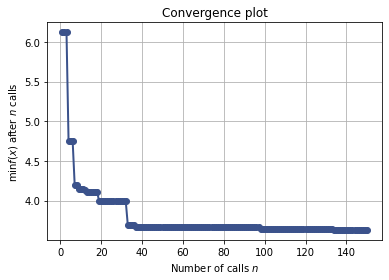

In [405]:
from skopt.plots import plot_convergence
plot_convergence(res);

[1e-06, 0.9108202623011344, 3.985964804675992, 2.6858537249574437]


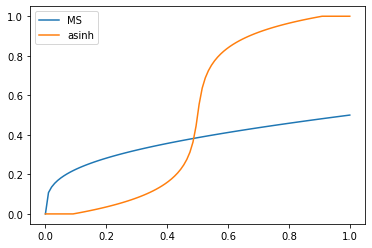

In [406]:
print(res.x)

plt.close('all')
plt.plot(xx, Mantiuk_Seidel(xx, *res.x), label='MS')
plt.plot(xx, asinh(xx), label='asinh')
plt.legend()
plt.plot();

## Visualize GP 

In [375]:
from skopt.plots import plot_evaluations

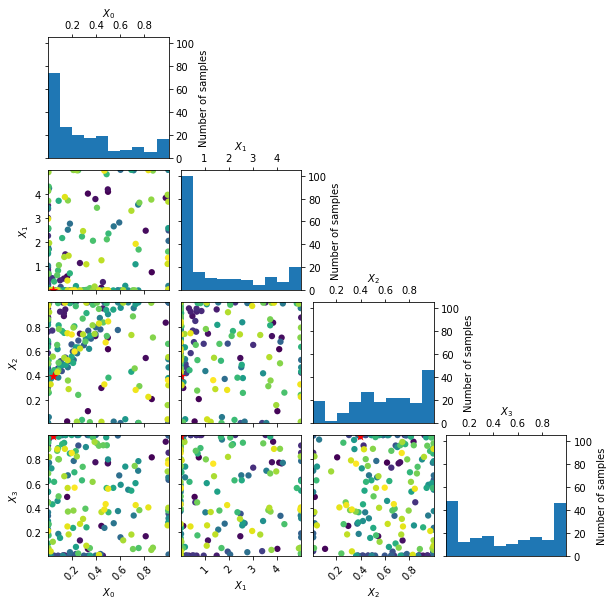

In [382]:
_ = plot_evaluations(res, bins=10)

### Partial dependence plots

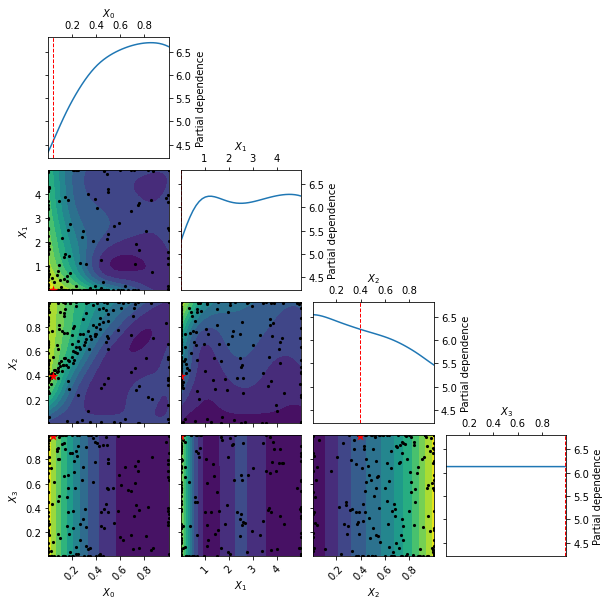

In [383]:
from skopt.plots import plot_objective

_ = plot_objective(res)

왜 이럴까... MS 통과하면 scale이 1에 가까울 방법이 없는건가...?? 

In [158]:
def Mantiuk_Seidel(lum, b, c, dl, dh):
        al = (c*dl-1)/dl # contrast compression for shadows
        ah = (c*dh-1)/dh
        lp = np.log10(lum) # L prime
        
        conditions=[lp <= b-dl,
                    (b-dl < lp) * (lp <= b),
                    (b < lp) * (lp <= b+dh),
                    lp > b+dh]
        
        functions=[0,
                   lambda lp : 1/2*c*(lp-b)/(1-al*(lp-b))+1/2,
                   lambda lp : 1/2*c*(lp-b)/(1+ah*(lp-b))+1/2,
                   1]
        
        return np.piecewise(lp, conditions, functions)

In [352]:
10**0.6 - 10**0.5

0.8187940453665927

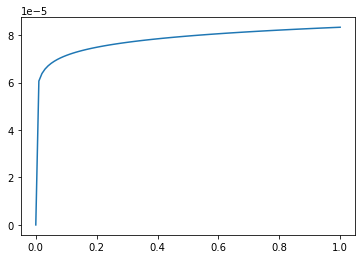

In [372]:
plt.plot(xx, Mantiuk_Seidel(xx, 20, 100, 30, 1))